# CrateRover Specs

This document records the specifications for the CrateRover, a robot designed to traverse semi-rough terrain to pick-up,
carry and deposit a single crate containing goods. The rover consists of a base, which provides the mobility, a cargo
platform, and a set of lifting arms, which can lift the cargo onto and off the base.




In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from robot_functions import *

## Requirements

The required performance values for the rover are defined as follows

### Cargo

The CrateRover should be able to carry a single [crate](https://www.mitre10.co.nz/shop/number-8-collapsible-crate-48-litre-blue/p/323388) with the
following dimensions and weight. 

In [2]:
# Cargo
cargo = Cargo(BoundingBox(0.520, 0.350, 0.268), 25.0)
cargo.to_dataframe()


,Cargo,Value
0,Maximum weight (kg),25.000
1,Length (m),0.520
2,Width (m),0.350
3,Height (m),0.268


### Rover

The performance requirements for the rover are set to allow the rover to carry some cargo over uneven terrain at speeds
that match human movement speeds. This gives us the following demands

* The ability to follow a human while carrying a load over uneven terrain. The assumption is that we want the rover to
  traverse at walking, 4 - 6 km/h, and running speed, 10 - 15 km/h.
* The ability to climb and descend steep slopes while carrying cargo.
* The ability to turn around on the spot in order to take sharp 90 degree corners.

These demands lead to the following performance envelope

In [3]:
# Rover performance
performance = RoverPerformance(1.5, 10.0, 20.0, 5.0)
performance.to_dataframe()

,Performance,Value
0,Maximum speed on the flat (m/s),1.5
1,Maximum hill angle without load (degrees),20.0
2,Maximum hill angle with load (degrees),10.0
3,Minimum battery life (hours),5.0


## Rover base

The rover base consists of the chassis, and the rover body. Each of these parts
are dimensioned based on the requirements for that part.

The rover chassis is the combination of the wheel assemblies and the framework that carries the
other parts. The chassis contains the suspension system, the steering and drive motors and wheels.

The rover body contains the electronics, a number of sensors, and the batteries.

Sizing the rover base is done by calculating the loads on the different components of the rover base. Some initial
part sizings are determined by the size of the cargo.

In [6]:
# Chassis
rover_wheel = RoverWheel(0.075)
rover_chassis = RoverChassis(
    BoundingBox(0.6, cargo.bounding_box.width_in_meters + 0.05, rover_wheel.radius_in_meters * 2 + 0.10),
    20.0,
    4, 
    rover_wheel)

rover = Rover(rover_chassis, cargo)

### Chassis

#### Stability

One of the important measures for the success of this project is the [stability](https://www.nap.edu/read/10308/chapter/4)
of the rover as it is traversing the ground, around corners, picking up the load from the ground and putting the load back
on the ground.

##### Static stability

Static stability refers to the potential for the vehicle to roll over, either side ways or front-to-back. This provides
a measure for the angle of a slope the rover can traverse without rolling over.

The static stability can be [calculated](file:///C:/Users/PETRIK~1.AD-/AppData/Local/Temp/the-static-stability-factor-a-dynamic-introduction-to-engineering.pdf)
using the following formula:

```
    roll_angle = atan( T / H )
```

Where `H` is the height of the center of gravity and `T` is the horizontal distance, between the center of gravity and
the wheel contact points. In order to calculate side-to-side roll angle `T` is the distance measured along the width of
the rover. In order to calculate the front-to-back roll angle `T` is the distance measured along the length of the rover.

For the current rover dimesions and weights the roll-over angles are:

In [7]:
# Static stability
chassis_cog = rover_chassis.center_of_gravity()
rover_cog = rover.center_of_gravity()

rover_no_load_side_to_side_roll_over_angle = 180 / math.pi * math.atan(chassis_cog.y / chassis_cog.z)
print('Roll-over angle')
print(f'Side to Side [No Load]\t{rover_no_load_side_to_side_roll_over_angle}')

rover_load_side_to_side_roll_over_angle = 180 / math.pi * math.atan(rover_cog.y / rover_cog.z)
print(f'Side to Side [Load]\t{rover_load_side_to_side_roll_over_angle}')

rover_no_load_front_to_back_roll_over_angle = 180 / math.pi * math.atan(chassis_cog.x / chassis_cog.z)
print(f'Front to Back [No Load]\t{rover_no_load_front_to_back_roll_over_angle}')

rover_load_front_to_back_roll_over_angle = 180 / math.pi * math.atan(rover_cog.x / rover_cog.z)
print(f'Front to Back [Load]\t{rover_load_front_to_back_roll_over_angle}')


Roll-over angle
Side to Side [No Load]	53.13010235415597
Side to Side [Load]	29.544634739569716
Front to Back [No Load]	63.43494882292201
Front to Back [Load]	40.37126933211608


##### Dynamic stability

Dynamic stability the resistance to roll over caused by taking a corner at a given velocity.

The minimum radius that the rover can take at a given speed and slope angle can be
[calculated](file:///C:/Users/PETRIK~1.AD-/AppData/Local/Temp/the-static-stability-factor-a-dynamic-introduction-to-engineering.pdf)
using the following formula:

```
    radius = (v^2) / g * ((T / H) * tan(slope) + 1) / ((T / H) - tan(slope))
```

Where `v` is the velocity of the rover, `g` is the gravitational acceleration and `slope` is the
angle of the slope in radians.

For the current rover dimensions and weights the minimum corner radius achievable without rolling over
is given by the following graphs:

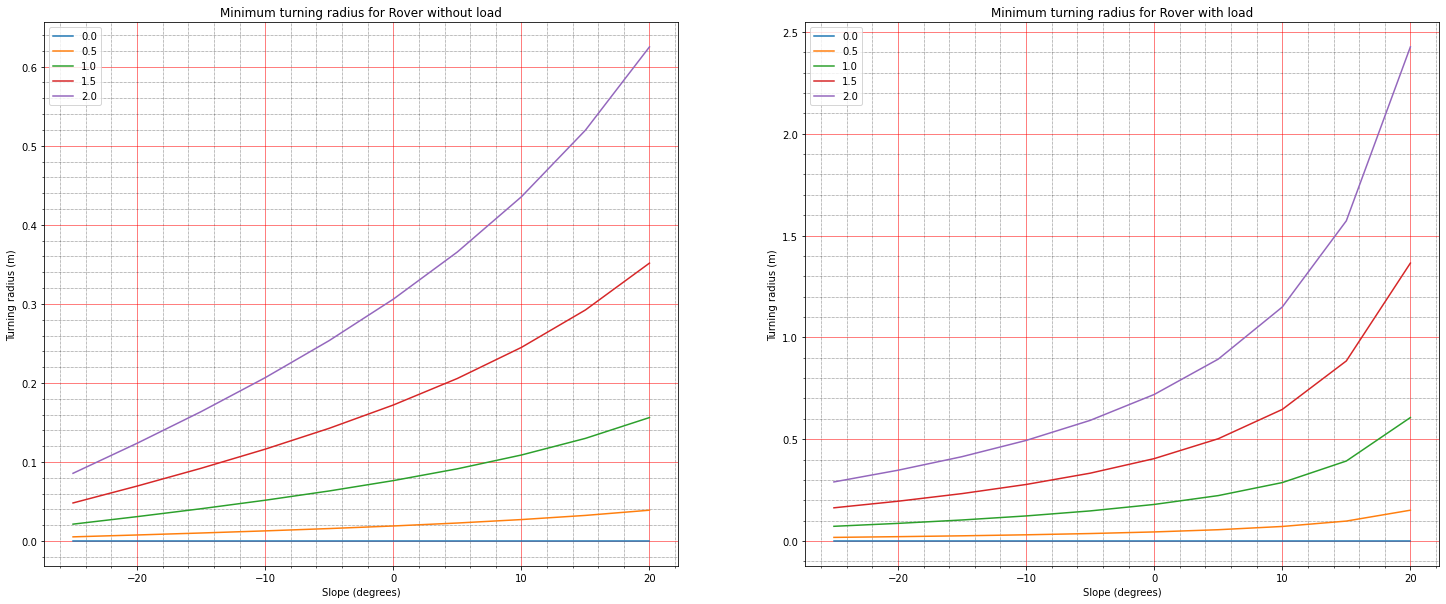

In [8]:
# Dynamic stability

radiusses_without_load = []
radiusses_with_load = []

columns = ['slope']

slope_step = 5.0
maximum_slope = performance.maximum_slope_angle_without_load() + slope_step
for slope in np.arange(-maximum_slope, maximum_slope, slope_step):

    radia_without_load = [ slope ]
    radia_with_load = [ slope ]

    velocity_step = 0.5
    for velocity in np.arange(0.0, performance.maximum_velocity_on_flat_ground() + velocity_step,
                            velocity_step):

        velocity_as_text = str(velocity)
        if velocity_as_text not in columns:
            columns.append(velocity_as_text)

        radius_no_load = corner_radius_for_velocity_and_angle(velocity, chassis_cog.y, chassis_cog.z, slope)
        radia_without_load.append(radius_no_load)
        
        radius_load = corner_radius_for_velocity_and_angle(velocity, rover_cog.y, rover_cog.z, slope)
        radia_with_load.append(radius_load)

    radiusses_without_load.append(radia_without_load)
    radiusses_with_load.append(radia_with_load)

radiusses_without_load_df = pd.DataFrame(radiusses_without_load, columns=columns)
radiusses_with_load_df = pd.DataFrame(radiusses_with_load, columns=columns)

fig, ax_group = plt.subplots(1, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

radiusses_without_load_df.plot(x='slope', ax=axs[0])
axs[0].set_title('Minimum turning radius for Rover without load')
axs[0].set_xlabel('Slope (degrees)')
axs[0].set_ylabel('Turning radius (m)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

radiusses_with_load_df.plot(x='slope', ax=axs[1])
axs[1].set_title('Minimum turning radius for Rover with load')
axs[1].set_xlabel('Slope (degrees)')
axs[1].set_ylabel('Turning radius (m)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')



### Drive system

One of the most important parts of the rover is the drive system. The required power and torgue necessary to move
the rover largely determines the size of the motors and batteries. Additionally the sizing of the drive system
will determine a large part of the weight of the rover.

The following calculations are based on the following [PhD thesis](https://www.chalmers.se/SiteCollectionDocuments/Energi%20och%20milj%C3%B6/Elteknik/EmmaGrunditz_PhDthesis_lowrez.pdf).

    Design and Assessment of Battery Electric Vehicle Powertrain, with Respect to Performance, Energy Consumption and Electric Motor Thermal Capability
    Emma Arfa Grunditz
    Department of Energy and Environment
    Division of Electric Power Engineering
    Chalmers University of Technology
    Gotenborg, Sweden 2016

The first part of the drive system calculation is to determine the following two parameters:

* The minimum torgue required to allow the rover to drive up the minimum required slope.
* The minimum power required to allow the rover to achieved the required transport velocity.

The following graphs provide insight in the wheel force and wheel power for different velocities and slope angles.

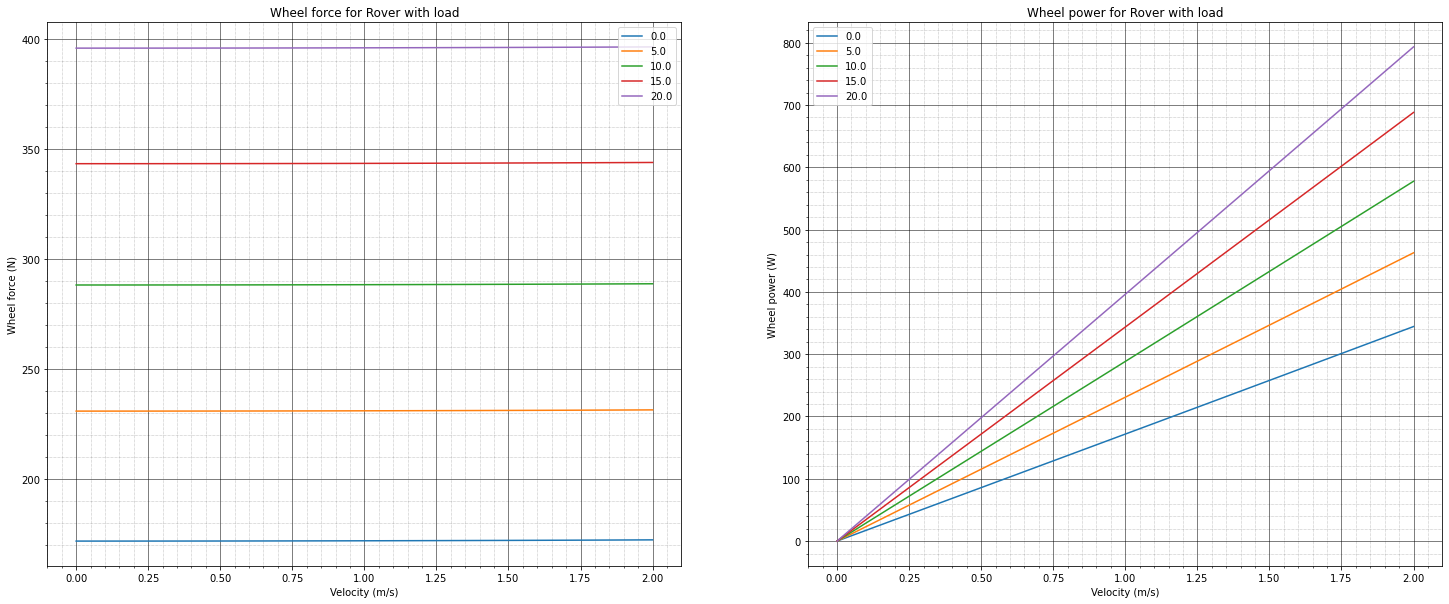

In [9]:
# Calculate wheel forces and wheel power
wheel_forces_without_load = []
wheel_power_without_load = []

wheel_forces_with_load = []
wheel_power_with_load = []
columns = ['velocity']

velocity_step = 0.1
for velocity in np.arange(0.0, performance.maximum_velocity_on_flat_ground() + velocity_step,
                          velocity_step):
    
    forces_without_load = [ velocity ]
    powers_without_load = [ velocity ]

    forces_with_load = [ velocity ]
    powers_with_load = [ velocity ]

    slope_step = 5.0
    for slope in np.arange(0.0, performance.maximum_slope_angle_without_load() + slope_step,
                           slope_step):

        slope_as_text = str(slope)
        if slope_as_text not in columns:
            columns.append(slope_as_text)

        wheel_force_without_load, power_without_load = wheel_load(
            rover.frontal_surface(),
            velocity,
            rover.weight_empty_in_kg(),
            slope)

        forces_without_load.append(wheel_force_without_load)
        powers_without_load.append(power_without_load)

        wheel_force_with_load, power_with_load = wheel_load(
            rover.frontal_surface(),
            velocity,
            rover.weight_load_in_kg(),
            slope)

        forces_with_load.append(wheel_force_with_load)
        powers_with_load.append(power_with_load)

    wheel_forces_without_load.append(forces_without_load)
    wheel_power_without_load.append(powers_without_load)

    wheel_forces_with_load.append(forces_with_load)
    wheel_power_with_load.append(powers_with_load)

force_without_load_df = pd.DataFrame(wheel_forces_without_load, columns=columns)
power_without_load_df = pd.DataFrame(wheel_power_without_load, columns=columns)

force_with_load_df = pd.DataFrame(wheel_forces_with_load, columns=columns)
power_with_load_df = pd.DataFrame(wheel_power_with_load, columns=columns)

fig, ax_group = plt.subplots(2, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

force_without_load_df.plot(x='velocity', ax=axs[0])
axs[0].set_title('Wheel force for Rover without load')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Wheel force (N)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

power_without_load_df.plot(x='velocity', ax=axs[1])
axs[1].set_title('Wheel power for Rover without load')
axs[1].set_xlabel('Velocity (m/s)')
axs[1].set_ylabel('Wheel power (W)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')


force_with_load_df.plot(x='velocity', ax=axs[2])
axs[2].set_title('Wheel force for Rover with load')
axs[2].set_xlabel('Velocity (m/s)')
axs[2].set_ylabel('Wheel force (N)')
axs[2].set_axisbelow(True)
axs[2].minorticks_on()
axs[2].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[2].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

power_with_load_df.plot(x='velocity', ax=axs[3])
axs[3].set_title('Wheel power for Rover with load')
axs[3].set_xlabel('Velocity (m/s)')
axs[3].set_ylabel('Wheel power (W)')
axs[3].set_axisbelow(True)
axs[3].minorticks_on()
axs[3].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[3].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

plt.show()

Once the force and power curves for different velocities and slope angles have been created the next step is to 
determine the velocity-force and velocity-acceleration diagrams. From these diagrams it is possible to determine the
characteristics of the rover engines.

In [15]:
# Determine minimum power and force requirements
minimum_power_required = power_with_load_df['0.0'][performance.maximum_velocity_on_flat_ground() * 10]
print(f'Minimum power required (Load) [W]\t{minimum_power_required}')
print()

force_at_zero_slope = minimum_power_required / performance.max_velocity
print(f'Force at zero slope (Load) [N]\t{force_at_zero_slope}')

torque_at_zero_slope = force_at_zero_slope * rover_wheel.radius_in_meters
print(f'Torque at zero slope (Load) [Nm]\t{torque_at_zero_slope}')
print()

velocity_max_at_max_slope = velocity_for_slope_and_power(
    minimum_power_required, 
    rover.frontal_surface(),
    rover.weight_load_in_kg(),
    performance.maximum_slope_angle_with_maximum_load())
print(f'Maximum velocity at maximum slope (Load) [m/s]\t{velocity_max_at_max_slope}')

force_at_max_slope = minimum_power_required / velocity_max_at_max_slope
print(f'Force at maximum slope [Load]\t{force_at_max_slope}')

torque_at_max_slope = force_at_max_slope * rover_wheel.radius_in_meters
print(f'Torque at maximum slope (Load) [Nm]\t{torque_at_max_slope}')
print()

# Grab the force required to drive up the slope for the given power, then calculate the closest
# multiple of 10N per wheel that is higher than this value.
minimum_force_for_acceleration = (((force_at_max_slope // rover_chassis.number_of_wheels) // 10) + 1) * 10 * rover_chassis.number_of_wheels
print(f'Minimum force for acceleration at maximum slope (Load) [N]\t{minimum_force_for_acceleration}')

# Calculate motor torque, motor speed and motor power

total_torgue = minimum_force_for_acceleration * rover_wheel.radius_in_meters
print(f'Torgue for maximum slope with spare [Nm]\t{total_torgue}')

Minimum power required (Load) [W]	344.3460299999999

Force at zero slope (Load) [N]	172.17301499999996
Torque at zero slope (Load) [Nm]	17.217301499999998

Maximum velocity at maximum slope (Load) [m/s]	1.1939421156857208
Force at maximum slope (Load) [N]	288.41099202052226
Torque at maximum slope (Load) [Nm]	28.841099202052227

Minimum force for acceleration at maximum slope (Load) [N]	320.0
Torgue for maximum slope with spare [Nm]	32.0


In [19]:
# Motor specifics

torque_at_zero_slope_per_motor = torque_at_zero_slope / rover_chassis.number_of_wheels
print(f'Torque at zero slope per wheel (Load) [Nm]\t{torque_at_zero_slope_per_motor}')

maximum_rotation_speed = performance.maximum_velocity_on_flat_ground() / (2.0 * math.pi * rover_wheel.radius_in_meters)
print(f'Rotation speed at zero slope [Hz]\t{maximum_rotation_speed}')
print(f'Rotation speed at zero slope [rpm]\t{maximum_rotation_speed * 60.0}')

power_at_zero_slope_per_motor = torque_at_zero_slope_per_motor * maximum_rotation_speed * 2.0 * math.pi
print(f'Power at zero slope per wheel [W]\t{power_at_zero_slope_per_motor}')
print()

torque_at_max_slope_per_motor = torque_at_max_slope / rover_chassis.number_of_wheels
print(f'Torque at maximum slope per wheel (Load) [Nm]\t{torque_at_max_slope_per_motor}')

maximum_slope_rotation_speed = velocity_max_at_max_slope / (2.0 * math.pi * rover_wheel.radius_in_meters)
print(f'Rotation speed at maximum slope [Hz]\t{maximum_slope_rotation_speed}')
print(f'Rotation speed at maximum slope [rpm]\t{maximum_slope_rotation_speed * 60.0}')

power_at_max_slope_per_motor = torque_at_max_slope_per_motor * maximum_slope_rotation_speed * 2.0 * math.pi
print(f'Power at maximum slope per wheel [W]\t{power_at_max_slope_per_motor}')

Torque at zero slope per wheel (Load) [Nm]	4.3043253749999995
Rotation speed at zero slope [Hz]	3.183098861837907
Rotation speed at zero slope [rpm]	190.98593171027443
Power at zero slope per wheel [W]	86.08650749999998

Torque at maximum slope per wheel (Load) [Nm]	7.210274800513057
Rotation speed at maximum slope [Hz]	1.9002178947697803
Rotation speed at maximum slope [rpm]	114.01307368618681
Power at maximum slope per wheel [W]	86.08650749999998


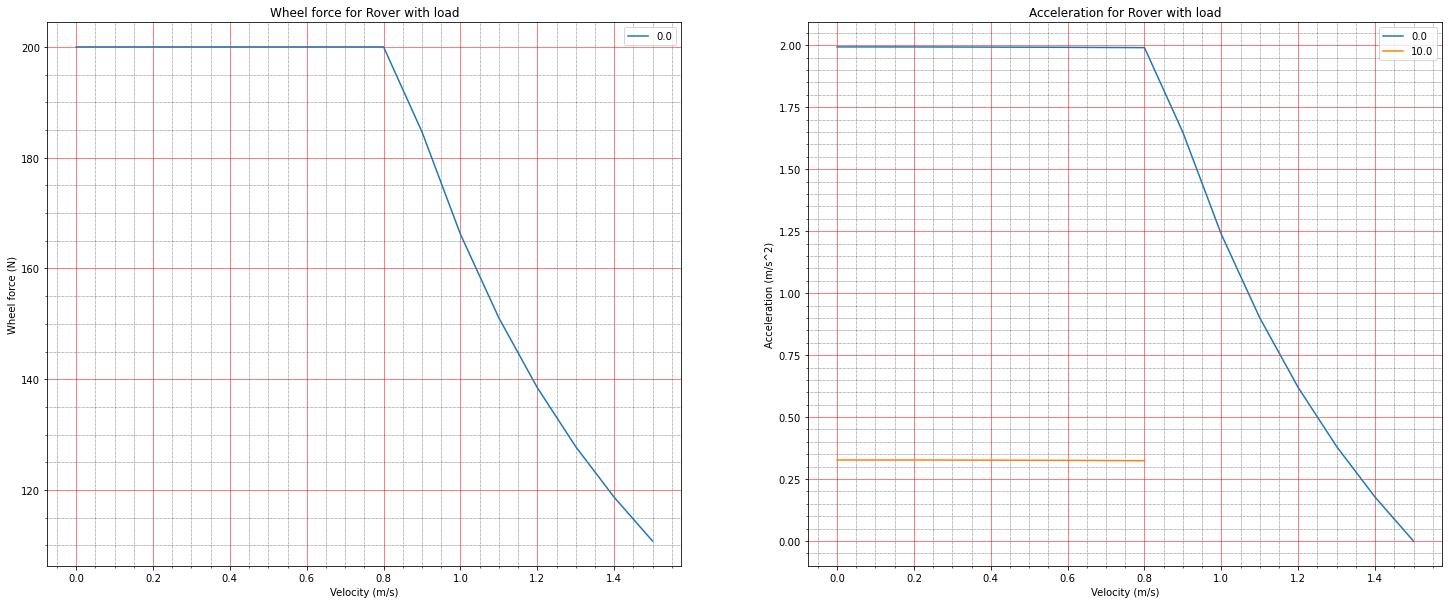

In [9]:
# Motor force and power curves
wheel_forces_for_power_curve = []
rover_acceleration_for_power_curve = []

velocity_step = 0.1
for velocity in np.arange(0.0, performance.maximum_velocity_on_flat_ground() + velocity_step,
                          velocity_step):
    forces_for_power_curve = [ velocity ]
    acceleration_for_power_curve = [ velocity ]
    
    if velocity < velocity_max_at_max_slope:
        force = minimum_force_for_acceleration
    else:
        power = minimum_power_required
        force = power / velocity

    forces_for_power_curve.append(force)

    minimum_force_flat, _ = wheel_load(
            rover.frontal_surface(),
            velocity,
            rover.weight_load_in_kg(),
            0)

    minimum_force_slope, _ = wheel_load(
            rover.frontal_surface(),
            velocity,
            rover.weight_load_in_kg(),
            performance.maximum_slope_angle_with_maximum_load())

    acceleration_flat = (force - minimum_force_flat) / (rover.weight_load_in_kg())
    acceleration_for_power_curve.append(acceleration_flat)

    if velocity < velocity_max_at_max_slope:
        acceleration_for_power_curve.append((force - minimum_force_slope) / (rover.weight_load_in_kg()))

    wheel_forces_for_power_curve.append(forces_for_power_curve)
    rover_acceleration_for_power_curve.append(acceleration_for_power_curve)

force_for_power_curve_df = pd.DataFrame(wheel_forces_for_power_curve, columns=['velocity', '0.0'])
acceleration_for_power_curve_df = pd.DataFrame(rover_acceleration_for_power_curve, columns=['velocity', '0.0', performance.maximum_slope_angle_with_maximum_load()])

fig, ax_group = plt.subplots(1, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

force_for_power_curve_df.plot(x='velocity', ax=axs[0])
axs[0].set_title('Wheel force for Rover with load')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Wheel force (N)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

acceleration_for_power_curve_df.plot(x='velocity', ax=axs[1])
axs[1].set_title('Acceleration for Rover with load')
axs[1].set_xlabel('Velocity (m/s)')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

Torgue and stuff

Selection of motors

Steering motor sizing

#### Battery sizing

* Separate motor power from compute power

Notes:

* We need to be able to accelerate when going up the hill otherwise we can't get going
* Need to figure out what our maximum force can be on the ground before we slip (can we even go up the hill?)
* Work out the torgue levels for the motors for each wheel
* Work out the power levels for the motors for each wheel


Further:

* Rover inertia?
* Wheel inertia
* Steering power
* Braking power
* Pick-up of cargo
  * From sides without falling over
* FMEA -> Failure Mode Effects Cricicallity Analysis -> Try to predict failures before they happen
* stability
  * Stability while lifting / lowering


Design:

* Brakes + hold power for on the hill / when loading
* Suspension for individual wheels. At 4.0 m/s hitting anything will be nasty because the swing arms are large with heavy weights at the end (the wheels + motors)
* System redundancy
* Monitoring
* Wheel slip detection
* CAD -> Should inform:
  * Electrical
  * Centre of Gravity / Center of intertia etc
  * Structural
  * ROS / Gazebo
* Inspiration
  * SPMT - Self-propelled modular transporter: https://www.mammoet.com/equipment/transport/self-propelled-modular-transporter/spmt/


Software:

* Communication
  * Push
  * Pull
  * Pub / Sub
  * Pub to blackboard (only keep last value)
* Logs
* Telemetry
* Safe guards
  * Will need a shutdown
  * Load guards
  * Roll-over etc.
  * Human detection / Damage detection
  * Software security
    * Encryption
    * Trust roots
    * Access permissions
    * Audits
* Architecture
  * Layers
    * Hardware interaction
    * Processing
    * Goal level
  * Lower layers run constantly + interupts / blocks from high level (see: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.110.809&rep=rep1&type=pdf)
  * Middleware / Comms
* Configuration management -> Pushing new software versions, new commands etc.
  * Default way of pushing changes
  * Audit log
* Links
  * https://robops.org/manifesto
  

Electronics

* Modules
  * Processing
  * PID / Control
  * Batteries
* Eventually use busses for power / data so that we can replace bits
* Safety switches
  * Global
  * Local
  * Depower sections / whole rover
  * Depower motor circuits
  * Depower logic circuits

## Rover arm sizing